## An A/B Testing Example

In [1]:
import pandas as pd
pd.set_option('display.max_rows',5)

In [2]:
import numpy as np

In [3]:
data = pd.read_csv('./data/cross_sell_email.csv')
data

,gender,cross_sell_email,age,conversion
0,0,short,15,0
1,1,short,27,0
...,...,...,...,...
321,1,no_email,16,0
322,1,long,24,1


In [4]:
# to estimate the causal effect, comppute the average
# conversion for each treatment group

# treatment groups are long, no_email, and short
# the control group is no_email
data.groupby(["cross_sell_email"]).mean()

,gender,age,conversion
cross_sell_email,,,
long,0.550459,21.752294,0.055046
no_email,0.542553,20.489362,0.042553
short,0.633333,20.991667,0.125000


In [5]:
# ATE ( average treatment effect)

# from above, the ATE measured as the difference between each
# treated group and the control group are:

#long = 5.5046% - 4.2553% = 1.3%
#short= 12.5% - 4.2553% = 8.3%

In [6]:
# a sanity check of randomized control trials (RCT) is to check if
# the treated are equal to the untreated in pretreatment variables

# this can be done by checking the normalized difference between
#the treatment groups

X = ["gender","age"]
mu=data.groupby(["cross_sell_email"])[X].mean()
var = data.groupby(["cross_sell_email"])[X].var()

# no_email is the baseline normalized value at zero
# if the treatment difference is 0.5 or higher, you should be worried
norm_diff = (mu-mu.loc["no_email"])/np.sqrt((var+var.loc["no_email"])/2)
norm_diff

,gender,age
cross_sell_email,,
long,0.015802,0.221423
no_email,0.000000,0.000000
short,0.184341,0.087370


In [7]:
mu

,gender,age
cross_sell_email,,
long,0.550459,21.752294
no_email,0.542553,20.489362
short,0.633333,20.991667


In [8]:
var

,gender,age
cross_sell_email,,
long,0.249745,33.521407
no_email,0.250858,31.542896
short,0.234174,34.562955


## The Most Dangerous Equation

In [9]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from cycler import cycler
import matplotlib


#modify some default values for matplotlib and plots
#default_cycler = cycler(color=['0.1','0.5','1.0'])

#color = ['0.3','0.5','0.7','0.9']
#linestyle = ['-','--',':','-.']
#marker = ['o','v','d','p']

#plt.rc('axes', prop_cycle=default_cycler)

#matplotlib.rcParams.update({'font.size':18})

In [10]:
df = pd.read_csv('./data/enem_scores.csv')
df

,year,school_id,number_of_students,avg_score
0,2007,11000058,144,69.03
1,2006,11000058,184,57.82
...,...,...,...,...
37939,2006,53014111,181,54.38
37940,2007,53014111,145,72.62


In [11]:
# notice the top average score has a lot less students
df.sort_values(by="avg_score", ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
...,...,...,...,...
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


In [12]:
# create box plot of 99% and top 1% of average scores
# split the data in plot_data into the 99% and 1%
# filter out schools with student count in the lowest 2% of schools
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], 0.99))
             [["top_school","number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'],0.98)}")
            )

In [13]:
plot_data

,top_school,number_of_students
0,False,144
1,False,184
...,...,...
37939,False,181
37940,True,145


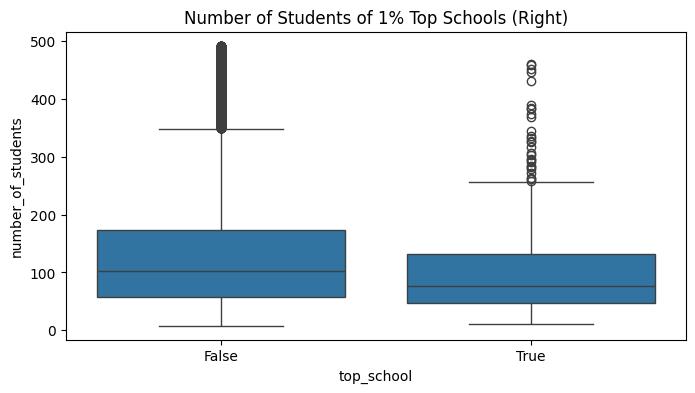

In [16]:
plt.figure(figsize=(8,4))
ax = sns.boxplot(x="top_school", y='number_of_students', data=plot_data)
plt.title("Number of Students of 1% Top Schools (Right)")
plt.show()

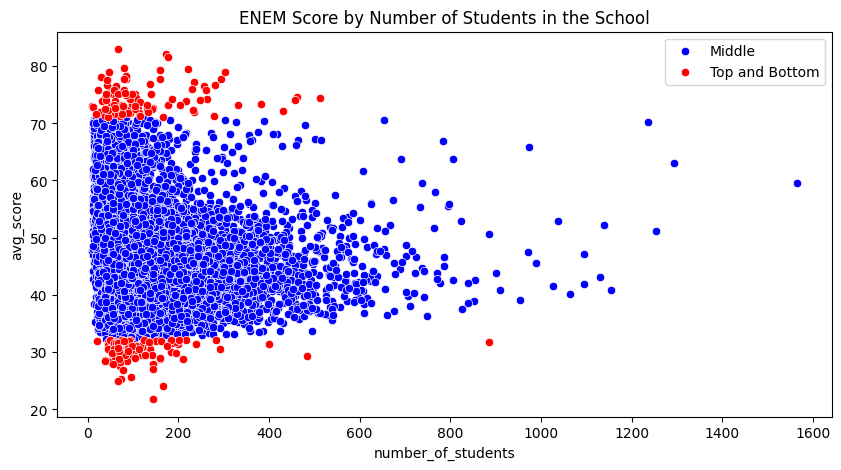

In [27]:
plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", 
                x="number_of_students", 
                data=plot_data.query("Group=='Middle'"), 
                color = 'b',
                label="Middle")
ax = sns.scatterplot(y="avg_score", 
                     x="number_of_students", 
                     data=plot_data.query("Group!='Middle'"), 
                     color='r',
                     label="Top and Bottom")

plt.title("ENEM Score by Number of Students in the School")
plt.show()

##  The Standard Error of Our Estimates

In [29]:
data = pd.read_csv("./data/cross_sell_email.csv")

short_email = data.query("cross_sell_email=='short'")["conversion"]
long_email = data.query("cross_sell_email=='long'")["conversion"]
email = data.query("cross_sell_email != 'no_email'")["conversion"]
no_email = data.query("cross_sell_email == 'no_email'")["conversion"]

data.groupby(["cross_sell_email"]).size()

cross_sell_email
long        109
no_email     94
short       120
dtype: int64

In [33]:
# create function to calculate standard error
def se(y: pd.Series):
    return y.std()/np.sqrt(len(y))

print("SE for Long Email:", se(long_email))
print("SE for Short Email:", se(short_email))

SE for Long Email: 0.02194602460918551
SE for Short Email: 0.030316953129541618


In [31]:
# create function to calculate standard error
def se2(y):
    return y.std()/np.sqrt(len(y))

print("SE for Long Email:", se2(long_email))
print("SE for Short Email:", se2(short_email))

SE for Long Email: 0.02194602460918551
SE for Short Email: 0.030316953129541618


In [34]:
print("SE for Long Email:", long_email.sem())
print("SE for Short Email:", short_email.sem())

SE for Long Email: 0.02194602460918551
SE for Short Email: 0.030316953129541618


## Confidence Intervals

In [35]:
n = 100
conv_rate = 0.08

def run_experiment():
    return np.random.binomial(1, conv_rate, size=n)

np.random.seed(42)

experiments = [run_experiment().mean() for _ in range(10000)]
    

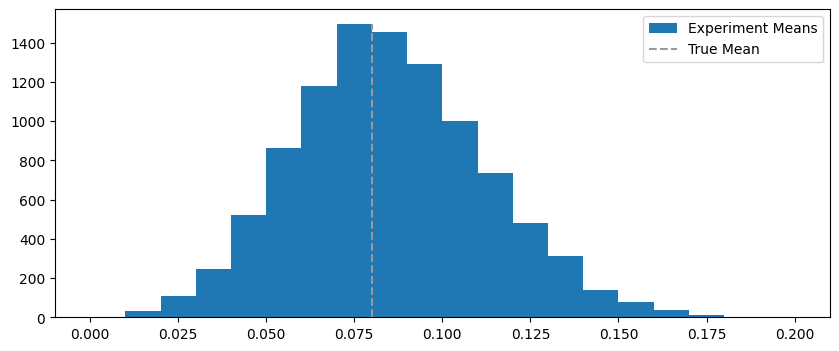

In [39]:
plt.figure(figsize=(10,4))
freq, bins, img = plt.hist(experiments, 
                           bins=20, 
                           label="Experiment Means")
plt.vlines(conv_rate, 
           ymin=0, 
           ymax=freq.max(), 
           linestyles="dashed", 
           label="True Mean",
           color="0.6")
plt.legend()

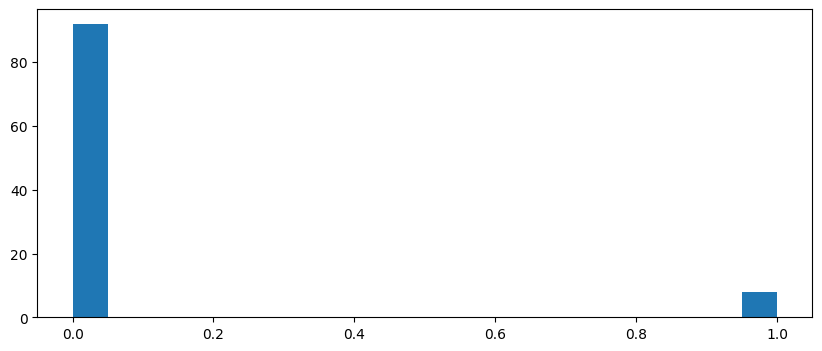

In [40]:
np.random.seed(42)
plt.figure(figsize=(10,4))
plt.hist(np.random.binomial(1,0.08,100), bins=20)
plt.show()

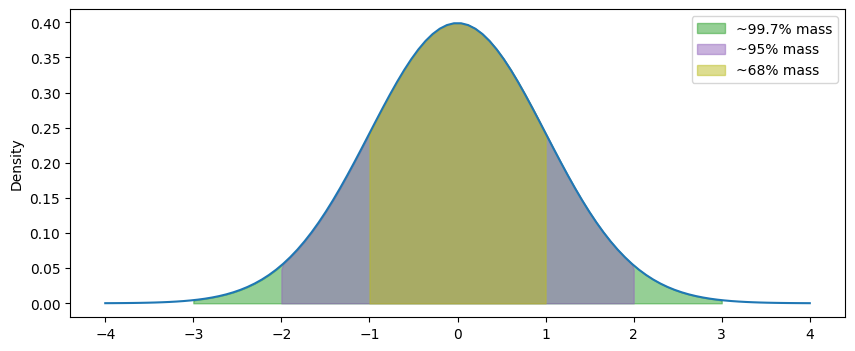

In [42]:
x = np.linspace(-4,4,100)
y = stats.norm.pdf(x, 0, 1)

plt.figure(figsize=(10,4))
plt.plot(x, y, linestyle="solid")
plt.fill_between(x.clip(-3, +3), 0, y, alpha=0.5,
                 label="~99.7% mass", color="C2")
plt.fill_between(x.clip(-2, +2), 0, y, alpha=0.5,
                 label="~95% mass", color="C4")
plt.fill_between(x.clip(-1, +1), 0, y, alpha=0.5,
                 label="~68% mass", color="C8")
plt.ylabel("Density")
plt.legend()
plt.show()

In [48]:
exp_se = short_email.sem()
exp_mu = short_email.mean()

#calculate the confidence interval
# which is between "Mean-(2*Standard Error) and Mean+(2* Standard Error)
ci = (exp_mu - 2* exp_se, exp_mu +2 * exp_se)

print(f"95% CI for Short Email: {ci}")

95% CI for Short Email: (0.06436609374091676, 0.18563390625908324)


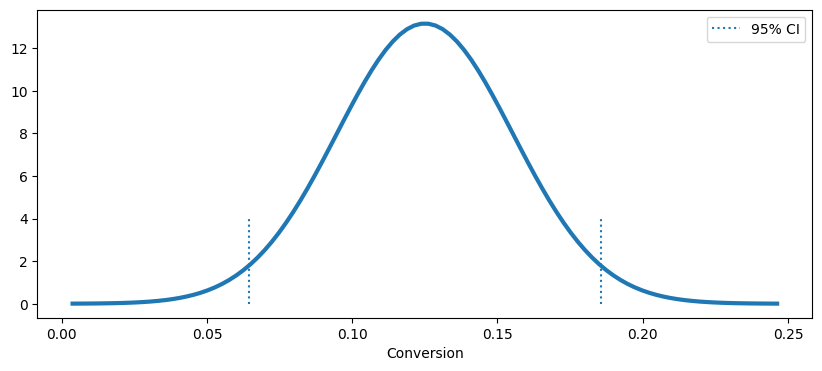

In [51]:
# plot the 95% confidence interval 
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)

plt.figure(figsize=(10,4))
plt.plot(x, y, lw=3)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="95% CI")
plt.xlabel("Conversion")
plt.legend()
plt.show()

In [52]:
from scipy import stats

In [66]:
# find the confidence interval for 99% confidence
# divide by 2 because there are 2 ends (left/right) on the curve
z = np.abs(stats.norm.ppf((1-0.99)/2))
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(0.04690870373460816, 0.20309129626539185)

In [67]:
# Find the point/factor where the normal distribution is 0.5%
stats.norm.ppf((1-0.99)/2)

-2.5758293035489004

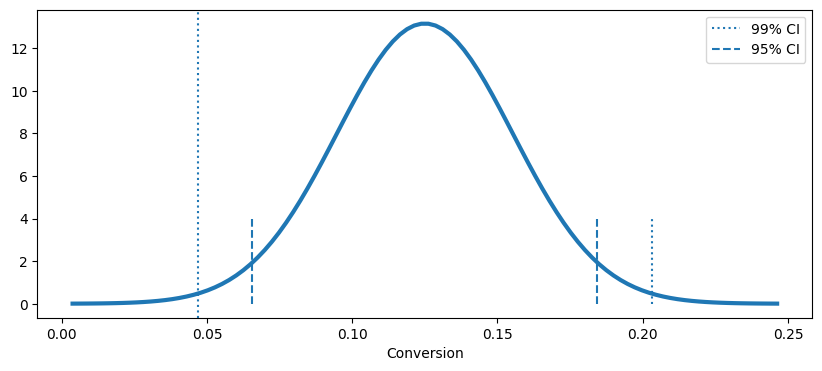

In [82]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se,100)
y = stats.norm.pdf(x, exp_mu, exp_se)

#lw is the linewidth
plt.figure(figsize=(10,4))
plt.plot(x,y,lw=3)

# vline and axvline appear to do the same but the ymin and ymax are different
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")

# left side line
plt.axvline(ci[0], ymin=0, ymax=1, ls="dotted", label="99% CI")

ci_95 = (exp_mu - 1.96 * exp_se, exp_mu + 1.96 * exp_se)

plt.vlines(ci_95[1], ymin=0, ymax=4, ls="dashed")
plt.vlines(ci_95[0], ymin=0, ymax=4, ls="dashed", label="95% CI")
plt.xlabel("Conversion")
plt.legend()

plt.show()

In [69]:
stats.norm.ppf(0.005)

-2.575829303548901

In [89]:
# Create function to calculate the confidence intervals
def ci(y: pd.Series):
    return (y.mean() - 2*y.sem(), y.mean() + 2*y.sem())

print("95% CI for Short Email", ci(short_email))
print("95% CI for Short Email", ci(long_email))
print("95% CI for Short Email", ci(no_email))

95% CI for Short Email (0.06436609374091676, 0.18563390625908324)
95% CI for Short Email (0.011153822341262012, 0.09893792077800405)
95% CI for Short Email (0.0006919679286838329, 0.08441441505003958)


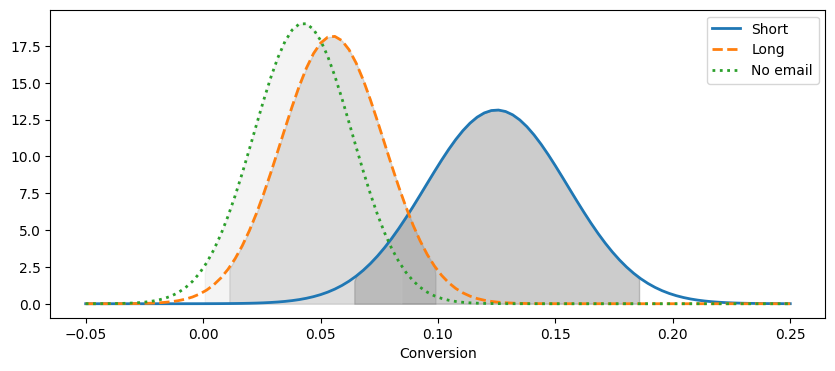

In [93]:
# All 3 overlap
# IF they did not overlap, you can say the difference in conversion 
#    between the groups is not simply buy chance and they are
#    statistically diffrent

# Overlapping CIs is not enough to say the difference betwwen the 
#    groups is not statistically significant


plt.figure(figsize=(10,4))

x = np.linspace(-0.05, .25, 100)
short_dist = stats.norm.pdf(x, short_email.mean(), short_email.sem())
plt.plot(x, short_dist, lw=2, label="Short", linestyle='-')
plt.fill_between(x.clip(ci(short_email)[0], ci(short_email)[1]), 0, short_dist, alpha=0.2, color="0.0")

long_dist = stats.norm.pdf(x, long_email.mean(), long_email.sem())
plt.plot(x, long_dist, lw=2, label="Long", linestyle='--')
plt.fill_between(x.clip(ci(long_email)[0], ci(long_email)[1]), 0, long_dist, alpha=0.2, color="0.4")

no_email_dist = stats.norm.pdf(x, no_email.mean(), no_email.sem())
plt.plot(x, no_email_dist, lw=2, label="No email", linestyle=':')
plt.fill_between(x.clip(ci(no_email)[0], ci(no_email)[1]), 0, no_email_dist, alpha=0.2, color="0.8")

plt.xlabel("Conversion")
plt.legend()

## Hypothesis Testing

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

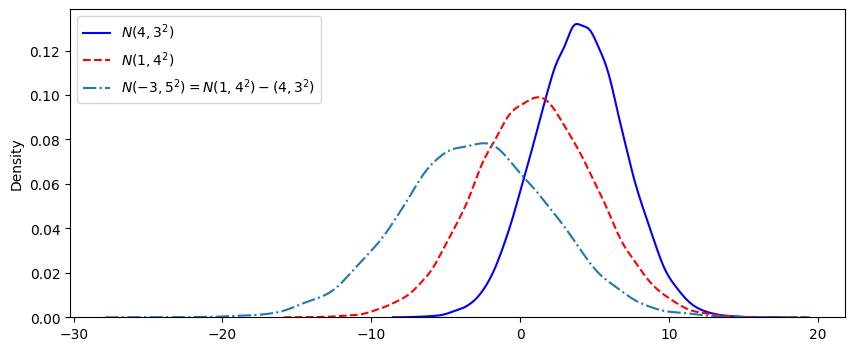

In [110]:
np.random.seed(123)

n1 = np.random.normal(4,3,30000)
n2 = np.random.normal(1,4,30000)
n_diff = n2-n1

plt.figure(figsize=(10,4))

# The label encapsulated by the $ values makes italicized letters
sns.distplot(n1, 
             hist=False, 
             label="$N(4,3^2)$", 
             color='b', 
             kde_kws={"linestyle":"-"})
sns.distplot(n2,
             hist=False,
             label="$N(1,4^2)$",
             color='r',
             kde_kws={"linestyle":"--"})

sns.distplot(n_diff,
             hist=False,
             label="$N(-3, 5^2) = N(1,4^2) - (4,3^2)$",
             kde_kws ={"linestyle":"-."})
plt.legend();

In [113]:
# calculate the confidence interval between the short email and no email
diff_mu = short_email.mean() - no_email.mean()
diff_se = np.sqrt(no_email.sem()**2 + short_email.sem()**2)

ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)

print(f"95% CI for the difference (short email - no email): \n{ci}")

95% CI for the difference (short email - no email): 
(0.010239808474398426, 0.15465380854687816)


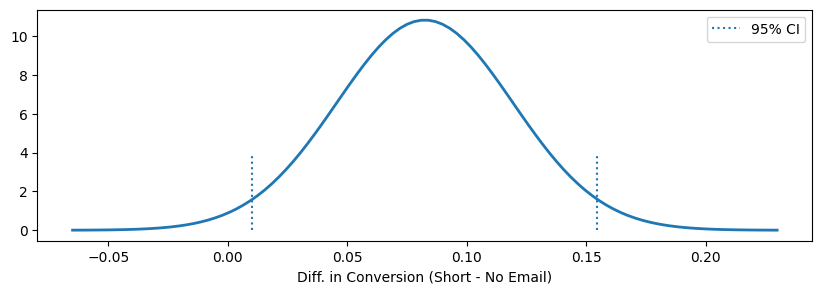

In [123]:
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)

plt.figure(figsize=(10,3))
plt.plot(x,y,lw=2)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="95% CI")
plt.xlabel("Diff. in Conversion (Short - No Email)")

# If a label is placed within a line or plot, use the legend to show the label
plt.legend()
plt.show()

### Null Hypothesis

In [129]:
# shifting the confidence interval (CI)
# 0.01 is to say 1% is the lift in conversion rate needed 
# to roll out the cross-sell email
diff_mu_shifted = short_email.mean() - no_email.mean() - 0.01
diff_se = np.sqrt(no_email.sem()**2 + short_email.sem()**2)

ci = (diff_mu_shifted - 1.96*diff_se, diff_mu_shifted + 1.96*diff_se)
print(f"95% CI for the difference (short email - no email): \n{ci}")

95% CI for the difference (short email - no email): 
(0.00023980847439843134, 0.14465380854687815)


### Test Statistic

In [130]:
# the zero below designates the null hypothesis conversion rate value
# Ho = Conversion(no_email) = Conversion(short_email)
# OR Conversion(no_email) - Conversion(short_email) = 0 (Conversion Rate)
t_stat = (diff_mu - 0) / diff_se
t_stat

2.237951231871536

## P-values

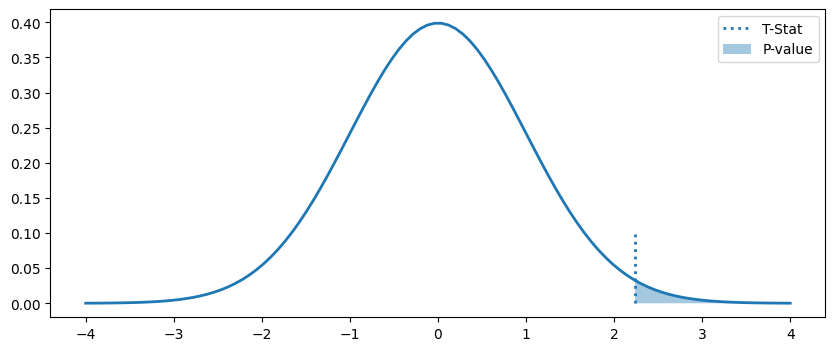

In [131]:
x = np.linspace(-4,4,100)
y = stats.norm.pdf(x, 0, 1)

plt.figure(figsize=(10,4))
plt.plot(x, y, lw=2)
plt.vlines(t_stat,
           ymin=0, 
           ymax=0.1, 
           ls="dotted", 
           label="T-Stat", 
           lw=2)
plt.fill_between(x.clip(t_stat), 
                 0, 
                 y, 
                 alpha=0.4,
                 label="P-value")
plt.legend()
plt.show()

In [132]:
print("P-value:", (1-stats.norm.cdf(t_stat))*2)

P-value: 0.025224235562152142


## Power

In [134]:
# The 0.84 is the value needed to return an 80% power rate
stats.norm.cdf(0.84)

0.7995458067395503

## Sample Size Calculation

In [137]:
# Calculate the sample size needed to achieve the 80% power
# and 95% significance
np.ceil(16 * (no_email.std()/0.08)**2)

103.0

In [139]:
# Retrieve the email type record counts
data.groupby("cross_sell_email").size()

cross_sell_email
long        109
no_email     94
short       120
dtype: int64